# ETH and S&P500 Clustering Analysis with Social Media Analysis

**Summary:** 
For this Python based project, I collected historical trading data for S&amp;P 500 companies and ETH-USD, and filtered 10,000 twitter posts, containing the words "ETH", "Ethereum". The project includes the following steps: collecting data,explore data, modify variables, setup model, and evaluate model. 
My hypothesis is that companies that are highly correlated will be affected by the same possitive or negative market information, and thus they should converge in market performance. I hope to find these companies.

**Presentation:** [`My Presentation for ETH_SP500_Analysis.pdf`](https://github.com/Jing0831/ETH_SP500_Clustering_Analysis/blob/801bbe34b2361cbab5f4cdb3f58386264995c317/ETH_SP500_Analysis_Presentation_JY.pdf)   

**Report:**  [`My Report for ETH_SP500_Analysis.pdf`](https://github.com/Jing0831/ETH_SP500_Clustering_Analysis/blob/801bbe34b2361cbab5f4cdb3f58386264995c317/ETH_SP500_Analysis_Report_JY.pdf)
         + [`Further Hotelling Test in R.pdf`](https://github.com/Jing0831/ETH_SP500_Clustering_Analysis/blob/ce8c56e0816115e6e1902d1a868ae8265e312438/Further%20Testing%20in%20R.pdf)

**Skills:** Data Collecting, Data Cleaning, EDA (exploratory data analysis), Time Series Processing, Clustering Analysis, Eblow Method, Social Media Analysis(text analysis, network analysis), Hypothesis Testing, Hoteling T^2 Testing, Data Visualization.  

**Technology:** Python (urllib, ssl, pandas, numpy, datetime, sklearn, Matplotlib), R(for Hoteling tesing only), Netlytic(for social media analysis only)

**Results:** Find a clear chain of industries related to blockchain computing resouces, and other interesting facts. 

## Step1. Scrape the wikipedia page relating to the list of S&P 500 companies

### a. Import Library:

In [41]:
import urllib.request
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
response = urllib.request.urlopen('https://www.python.org') # testing

In [7]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [8]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas_datareader

  Using cached pandas_datareader-0.10.0-py3-none-any.whl (109 kB)


### b. Read the S&P 500 Companies' list from Wikipedia

In [42]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

In [ ]:
df = table[0]
df.to_csv('S&P500-Info.csv') # Save the Info table for S&P500
df.to_csv("S&P500-list.csv", columns=['Symbol']) # Save the Symbols_list for S&P500

# c. Edit the list of desired stock names (add ETHUSD into our watching list)

In [ ]:
stock_list = pd.read_csv('S&P500-list.csv', index_col=[0])
Name_list = stock_list["Symbol"].tolist()
Name_list.append('ETH-USD')

### d. Crawling data from Yahoo

In [ ]:
data_source = 'yahoo' # Define the data source: Yahoo
start_date = '2021-09-01'
end_date = '2021-11-28'
data = web.DataReader(Name_list,data_source,start_date,end_date)
data.to_csv('stocks.csv') # Save as csv file

## Step 2. Data Preprocessing

In [11]:
stock_data = pd.read_csv('stocks.csv')
date =list(stock_data['Attributes'][2:])

### a. split into subsets and store as csv files

In [ ]:
## Open price
stock_open = stock_data.filter(regex='Open')
stock_open.columns = stock_open.iloc[0] # change column names
stock_open = stock_open[2:] # delete first two irrelevant rows
stock_open.index = date # Set the data as the index
stock_open.to_csv('Open.csv')

## Close price:
## I use the 'Adj Close' since this price is amended to account for any corporate actions.
stock_close = stock_data.filter(regex='Adj')
stock_close.columns = stock_close.iloc[0]
stock_close = stock_close[2:]
stock_close.index = date
stock_close.to_csv('Close.csv')

## Higest price for the date:
stock_high = stock_data.filter(regex='High')
stock_high.columns = stock_high.iloc[0]
stock_high = stock_high[2:]
stock_high.index = date
stock_high.to_csv('High.csv')

## Lowest price for the date:
stock_low = stock_data.filter(regex='Low')
stock_low.columns = stock_low.iloc[0]
stock_low = stock_low[2:]
stock_low.index = date
stock_low.to_csv('Low.csv')

## Volume
stock_Vol = stock_data.filter(regex='Volume')
stock_Vol.columns = stock_Vol.iloc[0]
stock_Vol = stock_Vol[2:]
stock_Vol.index = date
stock_Vol.to_csv('Volume.csv')

### b. Calculate the needed variables

In [ ]:
## Compute the Volatility Rate = (Max-Min)/Open;
High = pd.read_csv('High.csv').T
High.columns = High.iloc[0]
High = High[1:]

Low = pd.read_csv('Low.csv').T
Low.columns = Low.iloc[0]
Low = Low[1:]

Close = pd.read_csv('Close.csv').T
Close.columns = Close.iloc[0]
Close = Close[1:]

Open = pd.read_csv('Open.csv').T
Open.columns = Open.iloc[0]
Open = Open[1:]

Range = High - Low
Volatility = Range/Open
Volatility.to_csv('Volatility.csv')

# Compute the Movement Rate = (Today's Close Price - Yesterday's Close Price)/Yesterday's Close Price *100
Close_2 = np.array(Close.iloc[: , 1:61])
Close_1 = np.array(Close.iloc[: , 0:60])

Movement = Close_2 - Close_1
Move_rate = pd.DataFrame(Movement/Close_1)
col_date = Close.iloc[: , 1:61].columns
Move_rate.columns = col_date
Move_rate.index = Close.iloc[:].index
Move_rate.to_csv('Move_rate.csv')

# Compute the Opening Performance = (Today's Open Price - Yesterday's Close Price)/Yesterday's Close Price *100
Open_2 = np.array(Open.iloc[:,1:61])
Open_per = pd.DataFrame((Open_2 - Close_1)/Close_1)
Open_per.columns = col_date
Open_per.index = Open.iloc[:].index
Open_per.to_csv('Open_performance.csv')

### c. Combine the above three tables together (flatten the table) and save as csv. file

In [ ]:
Volatility = Volatility.drop(columns ='9/1/2021')
# flatten the table -- first column: stocks' names
stockslist = np.array(Volatility['index'])
day_n = 60
Name = list(np.repeat(stockslist,day_n)) # repeat every stock 60 times
Timelist = list(Move_rate.columns)
Timelist = Timelist*503 # repeat the timelist 503 times
pen_per_array = np.array(Open_per).flatten()
Volatility_array = np.array(Volatility).flatten()
Move_rate_array = np.array(Move_rate).flatten()
li = [Name, Timelist,Volatility_array, Open_per_array, Move_rate_array]
Flat_data = pd.DataFrame(data=li).T
Flat_data.columns=['Name','Date','Volatility','Open_per','Moverate']
Flat_data.to_csv('Flat_Data.csv')

## Step 3. Explore the dataset (Exploratory Data Analysis)

In [14]:
Flat_data = pd.read_csv('Flat_Data.csv')

<AxesSubplot:>

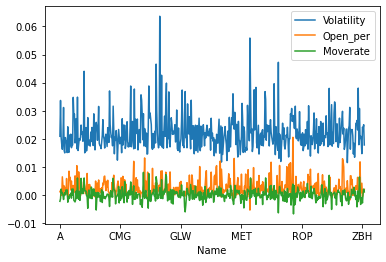

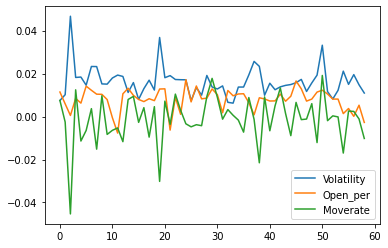

In [15]:
F = Flat_data.iloc[:, 1:]
F_S = Flat_data.iloc[0:59, 1:]
F.groupby(['Name']).mean().plot()
F_S.plot()

First chart shows that there is a large difference between the indicators of different stocks;
The second chart shows the performance of the stock MMM over 60 trading days, and we can pay particular attention to these peaks.

### slice the dataset by stock name and visualize distribution in boxplot:

Enter your stock:
ETH
       Unnamed: 0 Name        Date  Volatility  Open_per  Moverate
30180       30180  ETH    9/2/2021    0.027179 -0.002556 -0.011432
30181       30181  ETH    9/3/2021    0.081793 -0.000924  0.039469
30182       30182  ETH    9/4/2021    0.033398 -0.000686 -0.013395
30183       30183  ETH    9/5/2021    0.036204 -0.000385  0.016540
30184       30184  ETH    9/6/2021    0.025163 -0.000155 -0.006010
...           ...  ...         ...         ...       ...       ...
30264       30264  ETH  11/25/2021    0.070409  0.007409  0.008199
30265       30265  ETH  11/26/2021    0.136512  0.057890 -0.057041
30266       30266  ETH  11/27/2021    0.038133  0.002999  0.016374
30267       30267  ETH  11/28/2021    0.075079  0.001156  0.048217
30268       30268  ETH  11/29/2021    0.041039  0.000581  0.035080

[89 rows x 6 columns]


<AxesSubplot:>

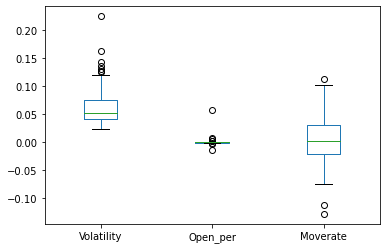

In [16]:
print('Enter your stock:')
x = input()
a = Flat_data.loc[Flat_data['Name'] == x]
print(a)
a.iloc[:, 1:].plot.box()

AAPL         AxesSubplot(0.1,0.15;0.363636x0.75)
AMZN    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

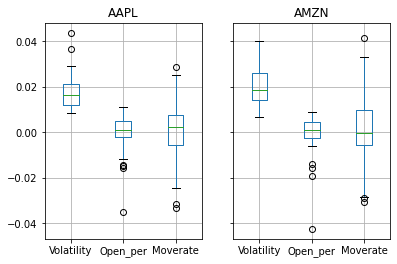

In [17]:
# boxplots across two stocks (Take AAPL and AMZN as example)
ETH = Flat_data.loc[Flat_data['Name'] == 'AAPL'].iloc[:, 1:]
NVDA = Flat_data.loc[Flat_data['Name'] == 'AMZN'].iloc[:, 1:]
frames = [ETH, NVDA]
result = pd.concat(frames)
result.groupby(['Name']).boxplot()

Above chart shows the distribution of AAPL and AMZN on the three indicators over a 60-day period.

## Step 4. K-Means Clustering Analysis

In [20]:
from sklearn.cluster import KMeans

<AxesSubplot:xlabel='Name'>

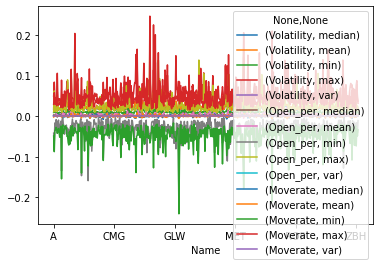

In [21]:
raw = pd.read_csv('Flat_Data.csv')
raw = raw.drop(raw.columns[0], axis=1)
table = raw.drop(raw.columns[1], axis=1)
T = table.groupby(['Name']).agg(['median','mean','min', 'max','var']).round(6)
T.plot()

In [22]:
T.columns = ['V_median','V_mean','V_min','V_max','V_var','O_median','O_mean','O_min','O_max','O_var',
             'M_median','M_mean','M_min','M_max','M_var']

### a. Elbow Method, determine how many clusters we need:

C:\Users\jwang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


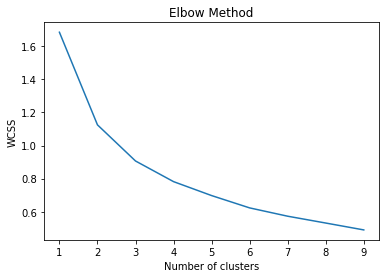

In [25]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=0)
    kmeans.fit(T)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


### b. K-Means, K=4 and K=6 applied

In [26]:
# k=4
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(T)
T['pred_4groups'] = pred_y.T
# k=6
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y2 = kmeans.fit_predict(T)
T['pred_6groups'] = pred_y2.T

### c. Visualization of the clustering results:

(array([265.,   0.,   9.,   0., 115.,   0.,  47.,   0.,  13.,  55.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

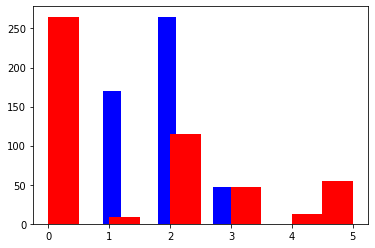

In [28]:
classifed = T[['pred_4groups', 'pred_6groups']]

plt.hist(T[['pred_4groups']],color='b', label='4 groups')
plt.hist(T[['pred_6groups']],color='r', label='6 groups')

### d. Visualization of the "ETH Group":

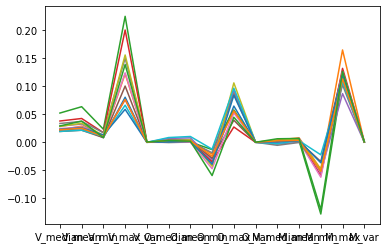

In [29]:
classifed[classifed.index == 'ETH']
a = T[T.pred_4groups == 0].drop(columns=['pred_4groups','pred_6groups'])
b = T[T.pred_6groups == 4].drop(columns=['pred_4groups','pred_6groups'])
all = pd.concat([a,b]).drop_duplicates()
plt.plot(b.T)

#### The clustered stocks show a clear trend towards similar market performance relative to the initial haphazard charts.

### Final list:

In [33]:
Final_list = list(b.reset_index()['Name'])

In [34]:
print(Final_list)

['BEN', 'DLTR', 'ETH', 'ETSY', 'F', 'FMC', 'LUMN', 'MTCH', 'NVDA', 'PFE', 'PWR', 'TER', 'TSLA']
